In [1]:
import numpy as np
from scipy.linalg import solve_banded
from scipy import linalg
from matplotlib import pyplot as plt

# Problem 1

Use the finite element method to solve
 
εy" − y' = −1,

y(0) = α, y(1) = β,


where α = 2, β = 4, and ε = 0.02. Use N = 100 finite elements (101 grid points). Compare
your solution with the analytic solution

y(x) = α + x + (β − α − 1)* (e^(x/ε) − 1)/(e^(1/ε) − 1) by graphing.


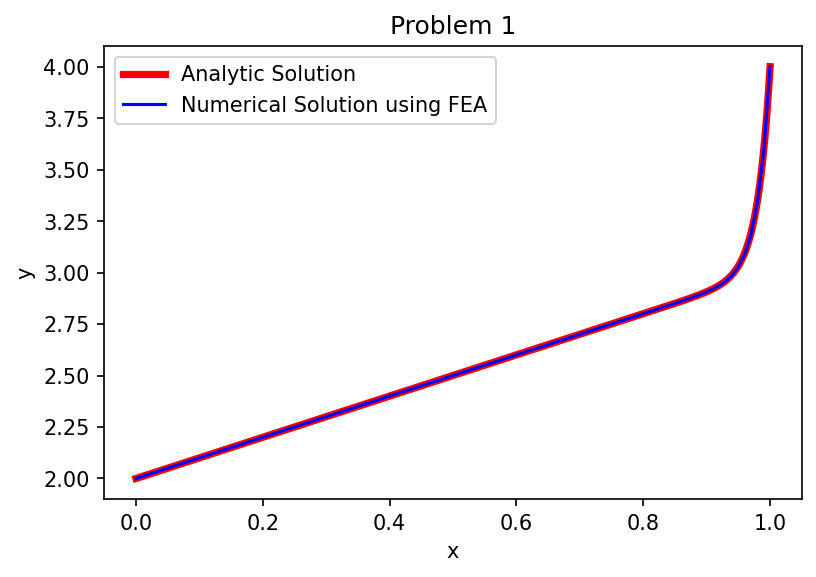

In [2]:
def FiniteElement( grid, alpha, beta, eps ):
    '''
    Performs finite element analysis on the heat equation
    :param grid: ( np.ndarray ) parameterized grid defining element domain
    :param alpha: ( float ) the minimum y value
    :param beta: ( float ) the maximum y value
    :param eps: ( float ) equation parameter
    :return K: ( np.ndarray ) basis coefficients
    '''
    #helper function to construct banded A matrix
    def a( i, j ):
        '''
        Integral evaluation to construct banded A matrix
        :param i: ( int ) basis function index
        :param j: ( int ) basis function index
        :return: ( float ) integral value
        '''
        if j == i + 1:
            hp1 = grid[ i + 1 ] - grid[ i ]
            return eps/hp1 + 1/2.
        elif j == i:
            h1 = grid[ i ] - grid[ i - 1 ]
            hp1 = grid[ i + 1 ] - grid[ i ]
            return -eps/h1 -eps/hp1
        elif j == i - 1:
            h1 = grid[ i ] - grid[ i - 1 ]
            return eps/h1 - 1/2.
        else:
            return 0
    #helper function to construct Phi vector
    def l( j ):
        '''
        Integral evluation to construc Phi vector
        :param j: ( int ) basis function index
        :return: ( float ) integral value
        '''
        h1 = grid[ j ] - grid[ j - 1 ]
        hp1 = grid[ j + 1 ] - grid[ j ]
        return -1*( h1 + hp1 ) / 2

    #construct Banded A matrix
    main_diag = np.ones_like( grid )
    main_diag[ 1:-1 ] = np.array([ a( i, i )
                                   for i in range( 1, grid.size - 1 ) ])

    sup_diag = np.zeros_like( grid )
    sup_diag[ 2: ] = np.array([ a( i + 1, i )
                                for i in range( 1, grid.size - 1 ) ])

    sub_diag = np.zeros_like( grid )
    sub_diag[ :-2 ] = np.array([ a( i, i + 1 )
                                 for i in range( 0, grid.size - 2 ) ])

    A_banded = np.vstack(( sup_diag, main_diag, sub_diag ))
    #delete arrays to free up space
    del( main_diag, sup_diag, sub_diag )
    #construct Phi
    Phi = np.empty_like( grid )
    Phi[ 0 ] = alpha
    Phi[ -1 ] = beta

    Phi[ 1:-1 ] = np.array([ l( j )
                             for j in range( 1, grid.size - 1 ) ])

    #we can now use the banded matrix solver.
    return solve_banded( ( 1, 1 ), A_banded, Phi )

#analytic solution function
def analytic_sol( x, a=2, b=4, eps=1/50. ):
    ''' Analytic solution for our PDE
    :param x: ( np.ndarray ) the evaluation point
    :param a: ( float ) minimum y value
    :param b: ( float ) maximum y value
    :param eps: ( float ) equation parameter
    :return eval: ( np.ndarray ) solution evaluation
    '''
    return a + x + ( b - a -1 ) * ( ( np.exp( x/eps ) - 1 )/( np.exp( 1/eps ) -1 ) )

def problem1():
    '''
    Computes problem 1
    '''
    #set domain and grid
    domain = np.linspace( 0, 1, 1000 )
    grid = np.linspace( 0, 1, 101 )
    #get numerical solution
    alpha, beta, eps = 2, 4, 1/50.
    K = FiniteElement( grid, alpha, beta, eps )
    #num_sol = compute_num_sol( domain, grid, alpha, beta, eps )

    #plot analytic solution and numerical solution
    fig, ax = plt.subplots( 1, 1 )
    fig.set_dpi( 150 )
    ax.plot( domain, analytic_sol( domain ), 'r-', linewidth=3.5, label='Analytic Solution' )
    ax.plot( grid, K, 'b-', label='Numerical Solution using FEA' )
    ax.legend( loc='best' )
    ax.set_xlabel( 'x' )
    ax.set_ylabel( 'y' )
    ax.set_title( 'Problem 1' )
    plt.show()

    return

problem1()

# Problem 2

Compare the numerical solution when the grid points are unevenly spaced versus when the grid points
are clustered in the area of greatest change by plotting.

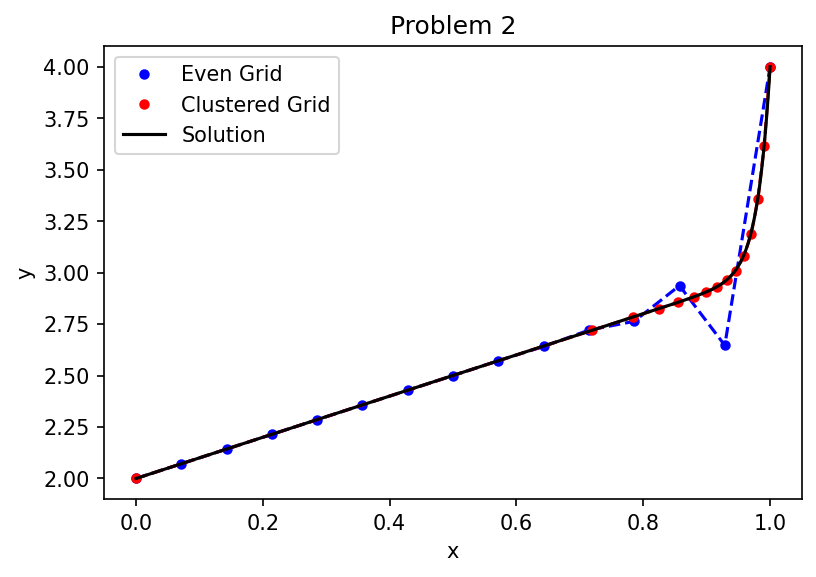

In [12]:
def problem2():
    '''
    Computes problem 2
    '''
    #set even and clustered grid
    even_grid = np.linspace( 0, 1, 15 )
    clustered_grid = np.linspace( 0, 1, 15 )**( 1/8. )
    #get numerical solution
    alpha, beta, eps = 2, 4, 1/50.
    #solve
    K_even = FiniteElement( even_grid, alpha, beta, eps )
    K_clustered = FiniteElement( clustered_grid, alpha, beta, eps )
    domain = np.linspace(0, 1, 1000)
    sol = analytic_sol( domain )

    #now plot and compare
    fig = plt.figure()
    fig.set_dpi( 150 )
    ax = fig.add_subplot( 111 )
    ax.plot( even_grid,K_even, 'bo', markersize=4, label='Even Grid' )
    ax.plot( even_grid,K_even, 'b--', markersize=1)
    ax.plot( clustered_grid, K_clustered, 'ro', markersize=4, label='Clustered Grid')
    ax.plot( clustered_grid, K_clustered, 'r--', markersize=4)
    ax.plot(domain, sol, 'k-', label='Solution')
    ax.legend( loc='best' )
    ax.set_xlabel( 'x' )
    ax.set_ylabel( 'y' )
    ax.set_title( 'Problem 2' )
    return

problem2()

# Problem 3

Solve (11.5) with the finite element method using N = 2^i finite elements, i = 4, 5, . . . , 21.

Use a log-log plot to graph the error.

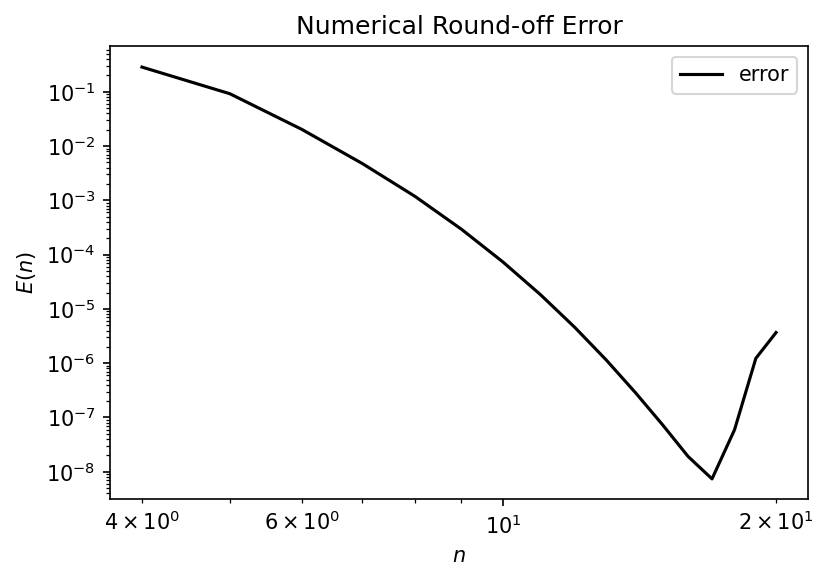

In [5]:
def problem3():
    '''
    computes problem 3
    '''
    alpha, beta, eps = 2, 4, 1/50.
    n_vals = np.arange( 4, 21 )
    Error = []
    for n in n_vals:
        grid = np.linspace( 0, 1, 2**n )
        curr_sol = FiniteElement( grid, alpha, beta, eps )
        true_sol = analytic_sol( grid )
        # compute_num_sol( domain, grid, alpha, beta, eps )
        curr_error = linalg.norm( curr_sol - true_sol, ord=np.inf )
        Error.append( curr_error )

    fig = plt.figure()
    fig.set_dpi( 150 )
    ax = fig.add_subplot( 111 )
    ax.loglog( n_vals, Error, 'k-', label='error' )
    ax.legend(loc='best')
    ax.set_ylabel( r'$E(n)$' )
    ax.set_xlabel( r'$n$' )
    ax.set_title( 'Numerical Round-off Error' )
    plt.show()

    return

problem3()